In [1]:
import numpy as np

import uproot
import awkward as ak
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory
from ntuple_schema import NtupleSchema
import hist

import mplhep as hep
import matplotlib.pyplot as plt

GeV = 1000

In [2]:
# mc20_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.deriv.DAOD_PHYS.e3601_s3681_r13167_p5267
file_path = "/gpfs/slac/atlas/fs1/d/recsmith/aswt/samples/FullCPAlgorithmsTest.mc.hist.root"

In [3]:
class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory(name="d_axis", label="", categories=[], growth=True)
        dielec_mass_axis = hist.axis.Regular(name="e_axis", label="$e\\bar{e}$ mass [GeV]", bins=50, start=0, stop=120)
        
        self.output = {'dielec_mass': hist.Hist(dataset_axis, dielec_mass_axis)}
    
    def process(self, events):
        
        elec = events.Electron
        # only want events with exactly two electrons with opposite charge
        dielec_neutral = elec[(ak.num(elec) == 2) & (ak.sum(elec.charge, axis=1) == 0)]
        dielec_mass = (dielec_neutral[:, 0] + dielec_neutral[:, 1]).mass
        
        dataset = events.metadata['dataset']
        self.output['dielec_mass'].fill(d_axis=dataset, e_axis=dielec_mass/GeV)
        
        return self.output
    
    def postprocess(self, accumulator):
        pass

In [4]:
file = uproot.open(file_path)
events = NanoEventsFactory.from_root(
    file, "analysis", metadata={"dataset": "Z$\\rightarrow e \\bar{e}$"}, schemaclass=NtupleSchema,
    entry_stop = 500
).events()
out = Processor().process(events)

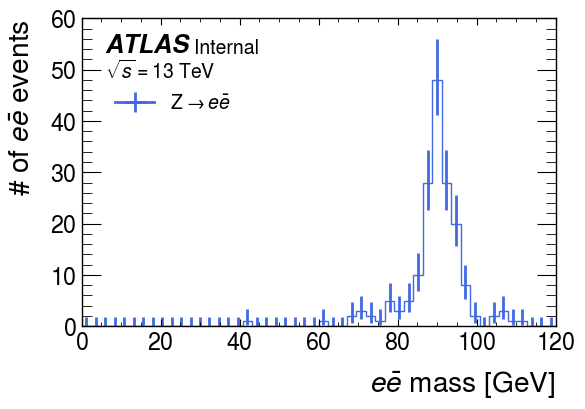

In [6]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=100)

out["dielec_mass"].plot1d(ax=ax, color="royalblue")

hep.style.use([hep.style.ATLAS])
hep.atlas.label(data=True, label="Internal")

ax.legend(bbox_to_anchor=(0.01, 0.85), loc="upper left")

ax.set_ylabel('# of $e\\bar{e}$ events')
plt.show()